Total patients: 1000
Patients with diabetes/prediabetes: 292
Patients with hypertension: 252
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       142
           1       0.56      0.38      0.45        58

    accuracy                           0.73       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.71      0.73      0.72       200

ROC AUC: 0.804820301117047


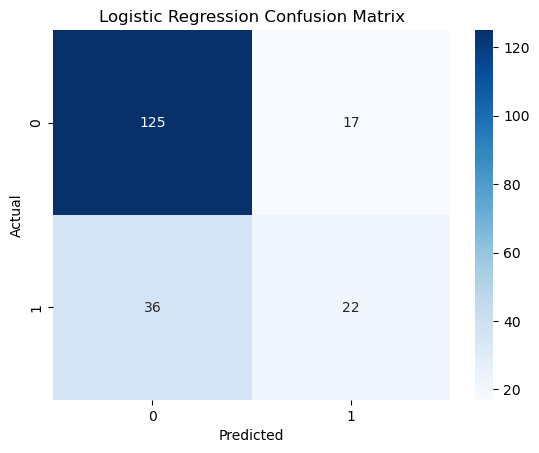

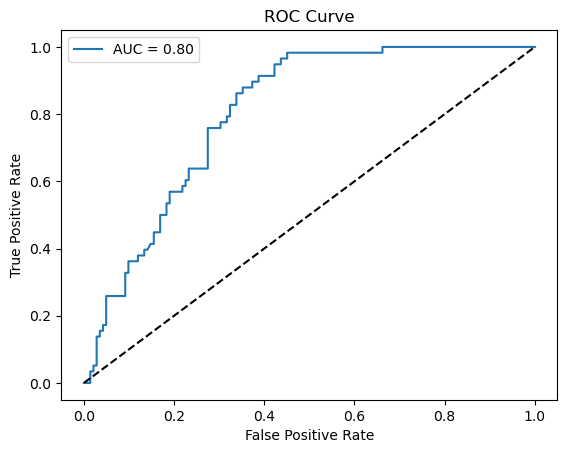


Feature Importance (Logistic Regression Coefficients):
        Feature  Coefficient  Abs_Coefficient
0           AGE     1.294211         1.294211
1           BMI     0.367821         0.367821
3   gender_male     0.220996         0.220996
2  hypertension     0.103007         0.103007


In [10]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- 2. Load Data ---
patients = pd.read_csv("patients.csv")
conditions = pd.read_csv("conditions.csv")
observations = pd.read_csv("observations.csv")

# --- 3. Compute AGE ---
patients["BIRTHDATE"] = pd.to_datetime(patients["BIRTHDATE"], errors="coerce")
patients = patients[patients["DEATHDATE"].isna()].reset_index(drop=True)
reference_date = pd.to_datetime("2025-01-01")
patients["AGE"] = (reference_date - patients["BIRTHDATE"]).dt.days // 365

# --- 4. Diabetes Outcome ---
diabetes_codes = ["44054006", "15777000"]
diabetes_patients = conditions[
    conditions["CODE"].astype(str).str.strip().isin(diabetes_codes)
]["PATIENT"].unique()
patients["diabetes_outcome"] = patients["Id"].isin(diabetes_patients).astype(int)

# --- 5. Hypertension Indicator ---
hypertension_patients = conditions[
    conditions["CODE"].astype(str).str.strip() == "59621000"
]["PATIENT"].unique()
patients["hypertension"] = patients["Id"].isin(hypertension_patients).astype(int)

# --- 6. BMI Extraction (LOINC 39156-5) ---
observations["DATE"] = pd.to_datetime(observations["DATE"], errors="coerce")
bmi_obs = observations[
    observations["CODE"] == "39156-5"
].sort_values(by=["PATIENT", "DATE"], ascending=[True, False])
bmi_latest = bmi_obs.groupby("PATIENT").first().reset_index()[["PATIENT", "VALUE"]]
bmi_latest.rename(columns={"VALUE": "BMI"}, inplace=True)

patients = patients.merge(bmi_latest, left_on="Id", right_on="PATIENT", how="left").drop(
    columns=["PATIENT"]
)
patients["BMI"] = pd.to_numeric(patients["BMI"], errors="coerce")
patients["BMI"] = patients["BMI"].fillna(patients["BMI"].mean())

# --- 7. Gender Encoding ---
patients["gender_male"] = (patients["GENDER"] == "M").astype(int)

# --- 8. Confirm Counts (like workshop) ---
print(f"Total patients: {len(patients)}")
print(f"Patients with diabetes/prediabetes: {patients['diabetes_outcome'].sum()}")
print(f"Patients with hypertension: {patients['hypertension'].sum()}")

# --- 9. Features and Outcome ---
X = patients[["AGE", "BMI", "hypertension", "gender_male"]]
y = patients["diabetes_outcome"]

# --- 10. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# --- 11. Scale Numeric Features ---
scaler = StandardScaler()
X_train[["AGE", "BMI"]] = scaler.fit_transform(X_train[["AGE", "BMI"]])
X_test[["AGE", "BMI"]] = scaler.transform(X_test[["AGE", "BMI"]])

# --- 12. Logistic Regression with Hyperparameter Tuning ---
param_grid_lr = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

grid_search_lr = GridSearchCV(
    lr, param_grid_lr, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search_lr.fit(X_train, y_train)

best_lr = grid_search_lr.best_estimator_
print("Best Parameters (Logistic Regression):", grid_search_lr.best_params_)

# --- 13. Evaluate Model ---
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# --- 14. Confusion Matrix ---
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 15. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- 16. Feature Coefficients (like suicide workshop) ---
feature_names = X.columns
coefficients = best_lr.coef_[0]
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients, "Abs_Coefficient": np.abs(coefficients)}
).sort_values(by="Abs_Coefficient", ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(importance_df)